In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Projekt - prva godina/kod/alldatasets_hr

[Errno 2] No such file or directory: '/content/drive/MyDrive/Projekt - prva godina/kod/alldatasets_hr'
/content


In [ ]:
# %cd /content/drive/MyDrive/Projekt - prva godina/kod

/content/drive/MyDrive/Projekt - prva godina/kod


# 03 - Sentence Classification with BERT

**Status: Work in progress. Check back later.**

In this notebook, we will use pre-trained deep learning models to process some text. We will then use the outputs of that models to classify the text. The text is a list of sentences from Booking reviews. And we will classify each sentence as either speaking "positively" about its subject or "negatively".

## Models
For classification we will use are machine learning using the Scikit Learn library. The deep learning model is BERT, DistilBERT, RoBERTa, AlBERTa and CroSloEngual BERT. We will use the implementation from the [huggingface transformers library](https://huggingface.co/).

## Dataset
The dataset we will use in this example is written in Croatian language, which contains sentences from booking reviews, each labeled as either positive (has the value 1) or negative (has the value 0):

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP models.

In [ ]:
!pip install lemmagen3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.5 MB 14.9 MB/s 
     |████████████████████████████████| 213 kB 74.4 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.2 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.7 MB/s 
     |████████████████████████████████| 6.6 MB 64.0 MB/s 
     |████████████████████████████████| 120 kB 77.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [ ]:
df = pd.read_excel('HRdataset.xlsx')

In [ ]:
df.head()

,review,label
0,Sve je bilo odlično. Gospođa koja nas je doček...,Positive
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",Positive
2,"Odlična lokacija, uredno, srdačna domaćica.",Positive
3,Malen i sladak apartman.,Positive
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,Positive


In [ ]:
df['label'] = df['label'].replace('Positive', 1)
df['label'] = df['label'].replace('Negative', 0)
df.tail()

,review,label
11462,Steta sto su prozori fiksni.,0
11463,NEMA BESPLATNOG PARKINGA!,0
11464,"Nemam odgovor, sve je EKSTRA!",0
11465,Jako uredno i čisto. Sve je kao i na slikama. ...,1
11466,"Domaćin ljubazan,lokacijama izvrsna udobno i č...",1


In [ ]:
df.shape

(11467, 2)

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()

2126


In [ ]:
print(df.isna().sum())
df = df.dropna()

review    2
label     0
dtype: int64


In [ ]:
df.shape

(9339, 2)

For performance reasons, we'll only use 5,000 sentences from the dataset

In [ ]:
# batch_1 = df[:5000]

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model.

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_class, tokenizer_class, pretrained_weights = (AutoModel, AutoTokenizer, 'EMBEDDIA/crosloengual-bert')

# EMBEDDIA/crosloengual-bert

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at EMBEDDIA/crosloengual-bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AlbertTokenizer, AlbertModel

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained("albert-base-v2")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Preparing the Dataset - Text preprocessing
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

#### Punctuation Removal

In [ ]:
#library that contains punctuation
import string

#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree= "".join([i for i in str(text) if i not in string.punctuation])
    return punctuationfree

#storing the puntuation free text
df['wop_review']= df['review'].apply(lambda x:remove_punctuation(x))
df.head()

,review,label,wop_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...


#### Lowering the text

In [ ]:
df['l_review']= df['wop_review'].apply(lambda x: x.lower())
df.head()

,review,label,wop_review,l_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...


#### Stop words removal

In [ ]:
%cd /content/drive/MyDrive/Projekt - prva godina/kod

/content/drive/MyDrive/Projekt - prva godina/kod


In [ ]:
my_file = open("stopwords_cro.txt", "r")
content = my_file.read()
stopwords_list = content.split("\n")
my_file.close()

In [ ]:
stopwords_list[0:10]

['a', 'ako', 'ali', 'bi', 'bih', 'bila', 'bili', 'bilo', 'bio', 'bismo']

In [ ]:
# defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
  output= " ".join([i for i in text.split(' ') if i not in stopwords_list])
  return output

In [ ]:
df['wos_review']= df['l_review'].apply(lambda x:remove_stopwords(x))

In [ ]:
df.head()

,review,label,wop_review,l_review,wos_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...


#### Stemming

In [ ]:
from StemmerHr.croatian_stemmer.stem import StemmerHr

stemmer = StemmerHr()
df['s_review']= df['wos_review'].apply(lambda x: stemmer.stem_text(x))
df.head()

,review,label,wop_review,l_review,wos_review,s_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...,"[odličn, gospođ, dočeka, jak, ljubazn, apartma..."
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...,"[lijep, uređen, prozračn, izuzetn, čist, odlič..."
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,"[odličn, lokacij, uredn, srdačn, domaćic]"
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman,"[malen, sladak, apartman]"
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...,"[apartman, izvrsn, lokacij, gospođ, ljubazn, d..."


#### Lematization

In [ ]:
from lemmagen3 import Lemmatizer

lem_hr = Lemmatizer('hr')
df['lem_review']= df['s_review'].apply(lambda x: " ".join([lem_hr.lemmatize(token) for token in x]))
df.head()

,review,label,wop_review,l_review,wos_review,s_review,lem_review
0,Sve je bilo odlično. Gospođa koja nas je doček...,1,Sve je bilo odlično Gospođa koja nas je dočeka...,sve je bilo odlično gospođa koja nas je dočeka...,odlično gospođa dočekala jako ljubazna apartma...,"[odličn, gospođ, dočeka, jak, ljubazn, apartma...",odličn gospođ dočekati jak ljubazn apartman či...
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1,Vrlo lijepo uređeno prozračno izuzetno čisto o...,vrlo lijepo uređeno prozračno izuzetno čisto o...,lijepo uređeno prozračno izuzetno čisto odličn...,"[lijep, uređen, prozračn, izuzetn, čist, odlič...",lijep urediti prozračn izuzetn čist odličn lok...
2,"Odlična lokacija, uredno, srdačna domaćica.",1,Odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,odlična lokacija uredno srdačna domaćica,"[odličn, lokacij, uredn, srdačn, domaćic]",odličn lokacij uredn srdačn domaćic
3,Malen i sladak apartman.,1,Malen i sladak apartman,malen i sladak apartman,malen sladak apartman,"[malen, sladak, apartman]",malen sladak apartman
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1,Apartman je na izvrsnoj lokaciji a gospođa je ...,apartman je na izvrsnoj lokaciji a gospođa je ...,apartman izvrsnoj lokaciji gospođa ljubazna do...,"[apartman, izvrsn, lokacij, gospođ, ljubazn, d...",apartman izvrsn lokacij gospođ ljubazn dozvoli...


In [ ]:
# sentence = df['Tweet'][0]
# tokens = sentence.split()
# sentence_lemmatized = ' '.join([lem_hr.lemmatize(token) for token in tokens])
# sentence_lemmatized



### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.head()

,Unnamed: 0,review,label,wop_tweet,l_tweet,wos_tweet,s_tweet,lem_tweet
0,9679,"Osoba na recepciji ljubazno nas je dočekala, d...",1,Osoba na recepciji ljubazno nas je dočekala do...,osoba na recepciji ljubazno nas je dočekala do...,osoba recepciji ljubazno dočekala dozvolila mo...,"[osob, recepcij, ljubazn, dočeka, dozvoli, ost...",osob recepcij ljubazn dočekati dozvoliti ostav...
1,1061,Doručak odličan. Lokacija izvrsna blizu autobu...,1,Doručak odličan Lokacija izvrsna blizu autobus...,doručak odličan lokacija izvrsna blizu autobus...,doručak odličan lokacija izvrsna blizu autobus...,"[doručak, odličan, lokacij, izvrsn, bliz, auto...",doručak odličan lokacij izvrsn bliz autobusn k...
2,8933,Sve pohvale domaćinu. Jako ljubazan i na usluz...,1,Sve pohvale domaćinu Jako ljubazan i na usluzi...,sve pohvale domaćinu jako ljubazan i na usluzi...,pohvale domaćinu jako ljubazan usluzi svojim g...,"[pohva, domaćin, jak, ljubazan, usluz, svoji, ...",pohva domaćin jak ljubazan usluz svoj gost apa...
3,9920,Cure na recepciji i sobarice.,1,Cure na recepciji i sobarice,cure na recepciji i sobarice,cure recepciji sobarice,"[cur, recepcij, sobaric]",cur recepcij sobaric
4,9392,Posebno mi se svidja cijena s obziron da smjes...,1,Posebno mi se svidja cijena s obziron da smjes...,posebno mi se svidja cijena s obziron da smjes...,posebno svidja cijena obziron smjestaji neposr...,"[posebn, svidj, cijen, obziron, smjestaj, nepo...",posebn svidj cijen obziron smjestajati neposre...


In [ ]:
# df.to_excel("shuffled.xlsx")

In [ ]:
batch_1 = df[:5000]

In [ ]:
batch_1['label'].value_counts()

1    3116
0    1884
Name: label, dtype: int64

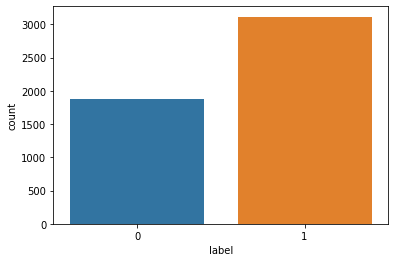

In [ ]:
ax = sns.countplot(batch_1.label)

In [ ]:
batch_1.isna().sum()

review        0
label         0
wop_review    0
l_review      0
wos_review    0
s_review      0
lem_review    0
dtype: int64

In [ ]:
# batch_1 = batch_1.dropna()

In [ ]:
tokenized = batch_1['lem_review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized

0       [103, 22078, 36779, 20339, 38302, 35842, 1007,...
1       [103, 22824, 16466, 12514, 14932, 1045, 29094,...
2       [103, 22078, 36779, 26752, 7334, 1045, 5871, 1...
3                   [103, 18493, 27896, 1353, 34328, 104]
4       [103, 34328, 27100, 26752, 20339, 38302, 13493...
                              ...                        
5760    [103, 25901, 1353, 12463, 25757, 1842, 18201, ...
5761    [103, 12897, 8566, 1035, 19170, 1007, 6049, 26...
5762    [103, 32608, 10341, 5991, 34123, 1353, 6217, 1...
5763    [103, 22824, 10331, 22443, 9881, 25901, 1353, ...
5764    [103, 31232, 3733, 32172, 13493, 13957, 19170,...
Name: lem_review, Length: 5000, dtype: object

In [ ]:
# batch_1['lem_review'][0]

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We define a PyTorch dataset and data loader for processing text data to tokenize and prepare text data for training a natural language processing (NLP) model.

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
MAX_LEN = 64

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 4000

train_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4000, 64])
torch.Size([4000, 64])
torch.Size([4000])


## Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [ ]:
# input_ids = torch.tensor(padded)
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
input_ids = torch.tensor(data['input_ids'])
attention_mask = torch.tensor(data['attention_mask'])

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features

array([[ 0.13227856, -0.2948353 , -1.6179051 , ..., -1.0634533 ,
        -0.9645592 ,  0.19221559],
       [-0.42615232, -0.53989965, -0.7229599 , ..., -0.31972075,
        -0.20996   ,  0.75825894],
       [-1.1016059 , -0.3673038 , -1.3941364 , ...,  0.57359344,
        -0.88391775,  1.5108069 ],
       ...,
       [ 0.58773327,  0.1754389 ,  0.79855764, ...,  0.961632  ,
        -1.1379882 , -0.7209443 ],
       [ 0.64344776,  0.33403274,  0.43379998, ...,  0.63396615,
        -0.7664388 , -0.70683134],
       [-0.42536804, -0.41580364, -0.7390994 , ..., -0.90765524,
        -0.42442062,  1.081722  ]], dtype=float32)

In [ ]:
features.shape

(4000, 768)

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [ ]:
labels = data['targets']

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size=0.8, random_state=42)

In [ ]:
# train_features.shape

(3200, 768)

In [ ]:
# test_features.shape

(800, 768)

## Models

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelBinarizer

In [ ]:
predict = []
y_array = []
cohen_1 = []
cohen_2 = []
auc_2 = []
auc_3 = []

from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
def metode(X_training,X_valid,y_training,y_valid):
  auc_1 = []
  lsvc_clf = LinearSVC()
  lsvc_clf.fit (X_training,y_training)
  pred_lsvc = lsvc_clf.predict(X_valid)
  acc_lsvc = accuracy_score(y_valid,pred_lsvc)
  pre_lsvc = precision_score(y_valid,pred_lsvc)
  r_lsvc = recall_score(y_valid,pred_lsvc)
  f1_lsvc = f1_score(y_valid,pred_lsvc)
  print("LinearSVC")
  print(classification_report(test_labels, pred_lsvc, target_names=target_names))
  print(metrics.confusion_matrix(y_valid,pred_lsvc))

  gnb_clf = GaussianNB()
  gnb_clf.fit(X_training,y_training)
  pred_gnb = gnb_clf.predict(X_valid)
  acc_gnb = accuracy_score(y_valid,pred_gnb)
  pre_gnb = precision_score(y_valid,pred_gnb)
  r_gnb = recall_score(y_valid,pred_gnb)
  f1_gnb = f1_score(y_valid,pred_gnb)
  print("GaussianNB")
  print(classification_report(test_labels, pred_gnb, target_names=target_names))

  dt_clf = DecisionTreeClassifier()
  dt_clf.fit(X_training,y_training)
  pred_dt = dt_clf.predict(X_valid)
  acc_dt = accuracy_score(y_valid,pred_dt)
  pre_dt = precision_score(y_valid,pred_dt)
  r_dt = recall_score(y_valid,pred_dt)
  f1_dt = f1_score(y_valid,pred_dt)
  print("DecisionTreeClassifier")
  print(classification_report(test_labels, pred_dt, target_names=target_names))

  rf_clf = RandomForestClassifier()
  rf_clf.fit(X_training,y_training)
  pred_rf = rf_clf.predict(X_valid)
  acc_rf = accuracy_score(y_valid,pred_rf)
  pre_rf = precision_score(y_valid,pred_rf)
  r_rf = recall_score(y_valid,pred_rf)
  f1_rf = f1_score(y_valid,pred_rf)
  print("RandomForestClassifier")
  print(classification_report(test_labels, pred_rf, target_names=target_names))

  svc_clf = SVC()
  svc_clf.fit (X_training,y_training)
  pred_svc = svc_clf.predict(X_valid)
  acc_svc = accuracy_score(y_valid,pred_svc)
  pre_svc = precision_score(y_valid,pred_svc)
  r_svc = recall_score(y_valid,pred_svc)
  f1_svc = f1_score(y_valid,pred_svc)
  print("SVC")
  print(classification_report(test_labels, pred_svc, target_names=target_names))

  lg_clf = LogisticRegression()
  lg_clf.fit(X_training,y_training)
  pred_lg = lg_clf.predict(X_valid)
  acc_lg = accuracy_score(y_valid,pred_lg)
  pre_lg = precision_score(y_valid,pred_lg)
  r_lg = recall_score(y_valid,pred_lg)
  f1_lg = f1_score(y_valid,pred_lg)
  print("LogisticRegression")
  print(classification_report(test_labels, pred_lg, target_names=target_names))

  kn_clf = KNeighborsClassifier()
  kn_clf.fit(X_training,y_training)
  pred_kn = kn_clf.predict(X_valid)
  acc_kn = accuracy_score(y_valid,pred_kn)
  pre_kn = precision_score(y_valid,pred_kn)
  r_kn = recall_score(y_valid,pred_kn)
  f1_kn = f1_score(y_valid,pred_kn)
  print("KNeighborsClassifier")
  print(classification_report(test_labels, pred_kn, target_names=target_names))

  predict.append(np.array([pred_lsvc, pred_gnb, pred_dt, pred_rf, pred_svc, pred_lg, pred_kn]))
  model_performance = pd.DataFrame({
    "Model": ["SVC", "Linear SVC", "Random Forest",
                  "Logistic Regression", "K Nearest Neighbors", "Gaussian Naive Bayes",
                  "Decision Tree"],
        "Accuracy": [acc_svc, acc_lsvc, acc_rf,
                  acc_lg, acc_kn, acc_gnb, acc_dt],
        "Precision": [pre_svc, pre_lsvc, pre_rf,
                  pre_lg, pre_kn, pre_gnb, pre_dt],
        "Recall": [r_svc, r_lsvc, r_rf,
                  r_lg, r_kn, r_gnb, r_dt],
        "F1-score": [f1_svc, f1_lsvc, f1_rf,
                  f1_lg, f1_kn, f1_gnb, f1_dt]

    })
  model_performance.sort_values(by="Accuracy", ascending=False)
  return model_performance

In [ ]:
print('CroSloEngular')
results = metode(train_features,test_features,train_labels,test_labels)

CroSloEngular
LinearSVC
              precision    recall  f1-score   support

     class 0       0.78      0.80      0.79       250
     class 1       0.91      0.90      0.90       550

    accuracy                           0.86       800
   macro avg       0.84      0.85      0.84       800
weighted avg       0.87      0.86      0.87       800

[[199  51]
 [ 57 493]]
GaussianNB
              precision    recall  f1-score   support

     class 0       0.65      0.88      0.75       250
     class 1       0.94      0.79      0.86       550

    accuracy                           0.82       800
   macro avg       0.80      0.83      0.80       800
weighted avg       0.85      0.82      0.82       800

DecisionTreeClassifier
              precision    recall  f1-score   support

     class 0       0.68      0.71      0.69       250
     class 1       0.86      0.85      0.86       550

    accuracy                           0.80       800
   macro avg       0.77      0.78      0.77    

In [ ]:
print("CroSloEngular")
results

CroSloEngular


,Model,Accuracy,Precision,Recall,F1-score
0,SVC,0.89000,0.894198,0.952727,0.922535
1,Linear SVC,0.86500,0.906250,0.896364,0.901280
2,Random Forest,0.87750,0.899293,0.925455,0.912186
3,Logistic Regression,0.88375,0.911712,0.920000,0.915837
4,K Nearest Neighbors,0.84750,0.856667,0.934545,0.893913
5,Gaussian Naive Bayes,0.81750,0.935345,0.789091,0.856016
6,Decision Tree,0.80375,0.864564,0.847273,0.855831


## Data exploration

In [ ]:
df['label'].value_counts()

1    5909
0    3430
Name: label, dtype: int64

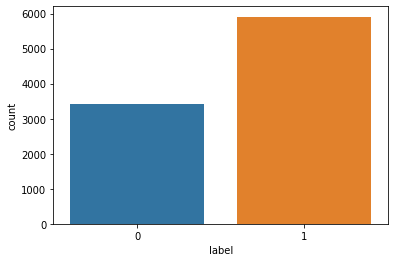

In [ ]:
ax = sns.countplot(df.label)

In [ ]:
positive = df['label'] == 1
df[positive]

,review,label
0,Sve je bilo odlično. Gospođa koja nas je doček...,1
1,"Vrlo lijepo uređeno, prozračno, izuzetno čisto...",1
2,"Odlična lokacija, uredno, srdačna domaćica.",1
3,Malen i sladak apartman.,1
4,Apartman je na izvrsnoj lokaciji a gospođa je ...,1
...,...,...
10985,"Vrlo udobna,prostrana i čista soba",1
10986,"Lokacija je fantastična, doslovno uz samu cent...",1
10987,Kupaona sa velikim tušem i lijepim ogledalom u...,1
10997,Jako uredno i čisto. Sve je kao i na slikama. ...,1


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

(-0.5, 799.5, 599.5, -0.5)

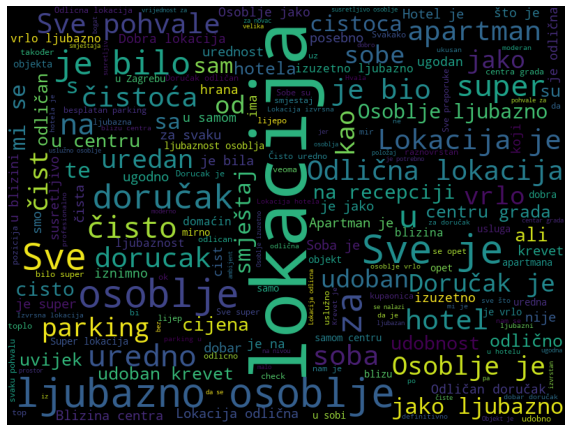

In [ ]:
cloud=WordCloud(width=800, height=600).generate(" ".join(df[positive]['review']))
plt.figure(figsize=(10,8))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
negative = df['label'] == 0
df[negative]

,review,label
50,Kucali nam na vrata da moramo izac jer je cisc...,0
51,Sve je bulo dobro.,0
52,cuju se “susjedi” iz drugog apartmana.,0
53,Sve je bilo u redu.,0
54,Nema toga😄,0
...,...,...
10993,Nemamo niti jednu zamjerku..,0
10994,Steta sto su prozori fiksni.,0
10995,NEMA BESPLATNOG PARKINGA!,0
10996,"Nemam odgovor, sve je EKSTRA!",0


(-0.5, 799.5, 599.5, -0.5)

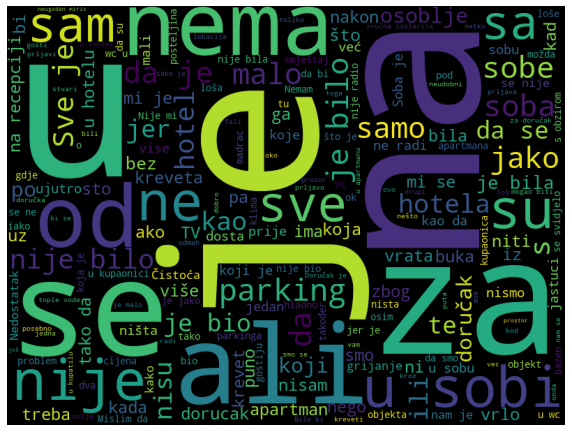

In [ ]:
cloud=WordCloud(width=800, height=600).generate(" ".join(df[negative]['review']))
plt.figure(figsize=(10,8))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# 10 najučestalijih tokena
from collections import Counter
counter_words = Counter()
import string

for word in words:
  if word not in string.punctuation:
    counter_words.update({word})
counter_words.most_common(10)

[('je', 2399),
 ('i', 1859),
 ('u', 1792),
 ('se', 1222),
 ('na', 1104),
 ('da', 1085),
 ('za', 934),
 ('nije', 809),
 ('ne', 529),
 ('bilo', 510)]

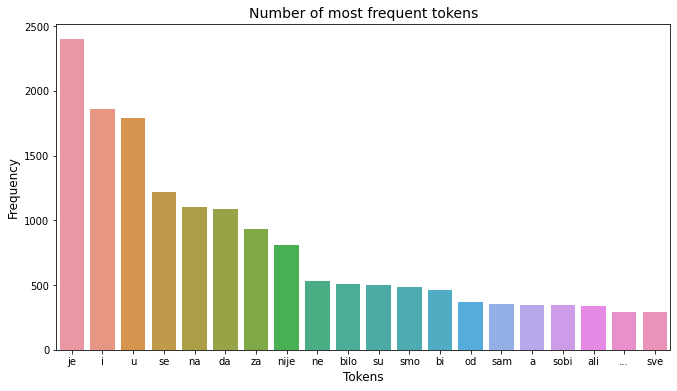

In [ ]:
# Vizualizacija 20 najčešćih tokena s njihovim frekvencijama
xs=[x for x, y in counter_words.most_common(20)]
ys=[y for x, y in counter_words.most_common(20)]
plt.figure(figsize = (11, 6))
sns.barplot(
x=xs[:20],
y=ys[:20])
plt.xlabel("Tokens", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.title('Number of most frequent tokens', fontsize = 14);
plt.show()

In [ ]:
import nltk
from nltk import pos_tag_sents # more magic
nltk.download('averaged_perceptron_tagger')
tagged_sentences = pos_tag_sents(sentences_with_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Funkcija koja vraća frekvencije riječi ovisno o definiciji
def count_word_type(tagged_sentences, word_type_tag = "NN"):
  counter = Counter()
  for sentence in tagged_sentences:
    for word, tag in sentence:
      if word_type_tag in tag and len(word) > 4:
        counter.update({word})
  return counter

In [ ]:
# 20 najčešćih imenica
count_word_type(tagged_sentences, "JJ").most_common(20)

[('nismo', 49),
 ('ujutro', 43),
 ('nisam', 43),
 ('nakon', 29),
 ('super', 24),
 ('nešto', 22),
 ('netko', 22),
 ('nista', 20),
 ('užasno', 20),
 ('uvijek', 18),
 ('nalazi', 17),
 ('neudoban', 16),
 ('ništa', 15),
 ('nedostatak', 15),
 ('umjesto', 14),
 ('neugodan', 14),
 ('uglavnom', 13),
 ('uopće', 13),
 ('nekim', 13),
 ('nemam', 13)]

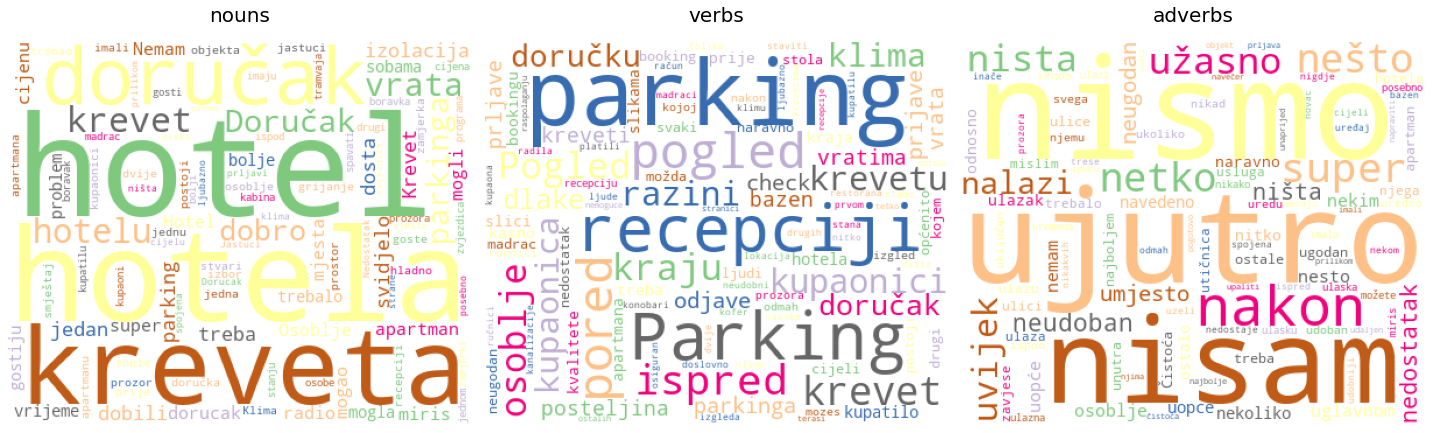

In [ ]:
from wordcloud import WordCloud
# Vizualizacija najčešćih imenica, pridjeva i glagola u kratkim sadržajima
fig = plt.figure(figsize=(20,10))
tags = {"NN": "nouns", "VB": "verbs", "JJ": "adverbs"}
for i, tag in enumerate(tags.keys()):
  plt.subplot(1,3,i+1)
  counter = count_word_type(tagged_sentences, tag)
  wc = WordCloud(
    width=400,
    height=330,
    max_words=100,
    colormap="Accent",
    background_color="white").generate_from_frequencies(counter)
  plt.imshow(wc)
  plt.axis("off")
  plt.title(tags[tag], fontsize=20, pad=20)
plt.tight_layout()
plt.show()